# Laboratorio #8 – Clasificación de Malware

# Librerías

In [13]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageOps
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# EDA

In [15]:
datasetPath = "malimg_paper_dataset_imgs"
families = os.listdir(datasetPath)
familiesCount = {familia: len(os.listdir(os.path.join(datasetPath, familia))) for familia in families}
familiesCount = dict(sorted(familiesCount.items(), key=lambda x: x[1], reverse=True))

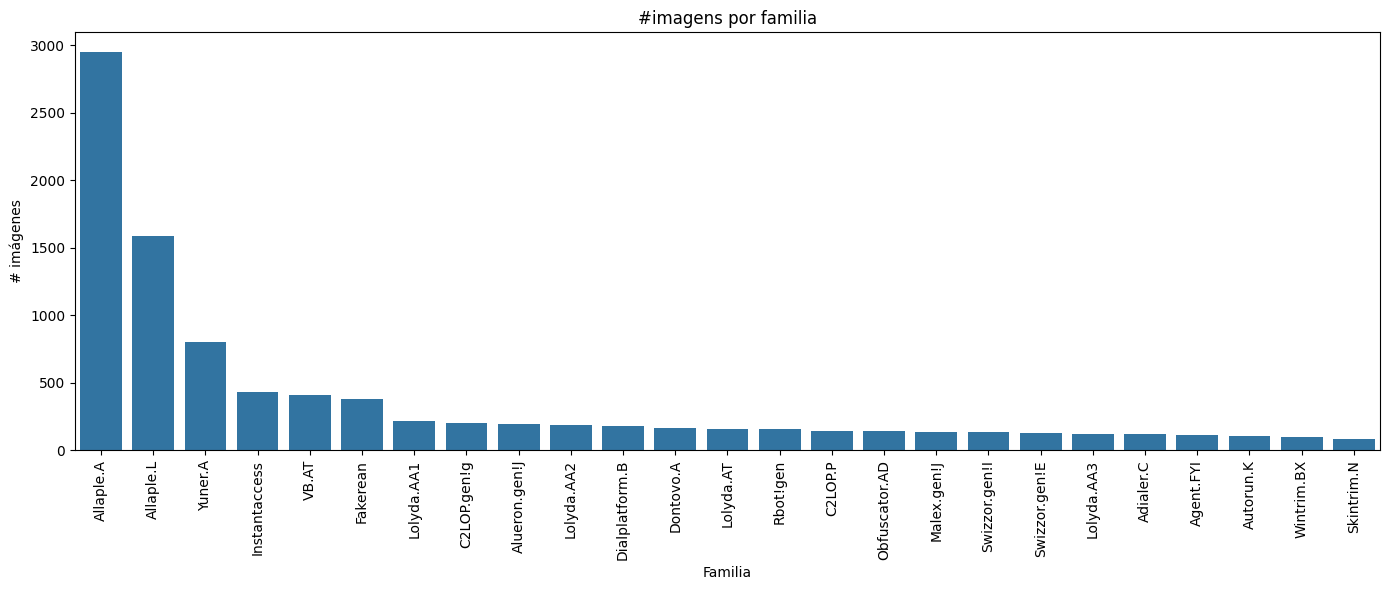

In [16]:
plt.figure(figsize=(14, 6))
sns.barplot(x=list(familiesCount.keys()), y=list(familiesCount.values()))
plt.xticks(rotation=90)
plt.title("#imagens por familia")
plt.xlabel("Familia")
plt.ylabel("# imágenes")
plt.tight_layout()
plt.show()

Teniendo en cuenta la cantidad de datos con las que se cuenta para cada una de las clases y viendo el gran desbalanceo que existe consideré conveniente el eliminar 3 clases. Las últimas tres clases que tienen pocos datos a comparación del resto. 
Además de esto, la clase `Allaple.A` cuenta con una gran cantidad de datos, con una gran diferencia con la segunda clase con más datos, por lo que también consideré conveniente el reducir la cantidad de datos de esta clase para evitar que el modelo pueda llegar a generar un sesgo hacia dicha clase.

In [17]:
toReduce = "Allaple.A"
maxValue = 1500
pathToReduce = os.path.join(datasetPath, toReduce)
images = os.listdir(pathToReduce)

if len(images) > maxValue:
    excedentes = random.sample(images, len(images) - maxValue)
    for archivo in excedentes:
        os.remove(os.path.join(pathToReduce, archivo))

In [18]:
dirToDelete = ['Skintrim.N', 'Wintrim.BX', 'Autorun.K']
for path in dirToDelete:
    pathToDelete = os.path.join(datasetPath, path)
    if os.path.exists(pathToDelete):
        for archivo in os.listdir(pathToDelete):
            os.remove(os.path.join(pathToDelete, archivo))
        os.rmdir(pathToDelete)

In [23]:
families = os.listdir(datasetPath)
familiesCount = {familia: len(os.listdir(os.path.join(datasetPath, familia))) for familia in families}
familiesCount = dict(sorted(familiesCount.items(), key=lambda x: x[1], reverse=True))

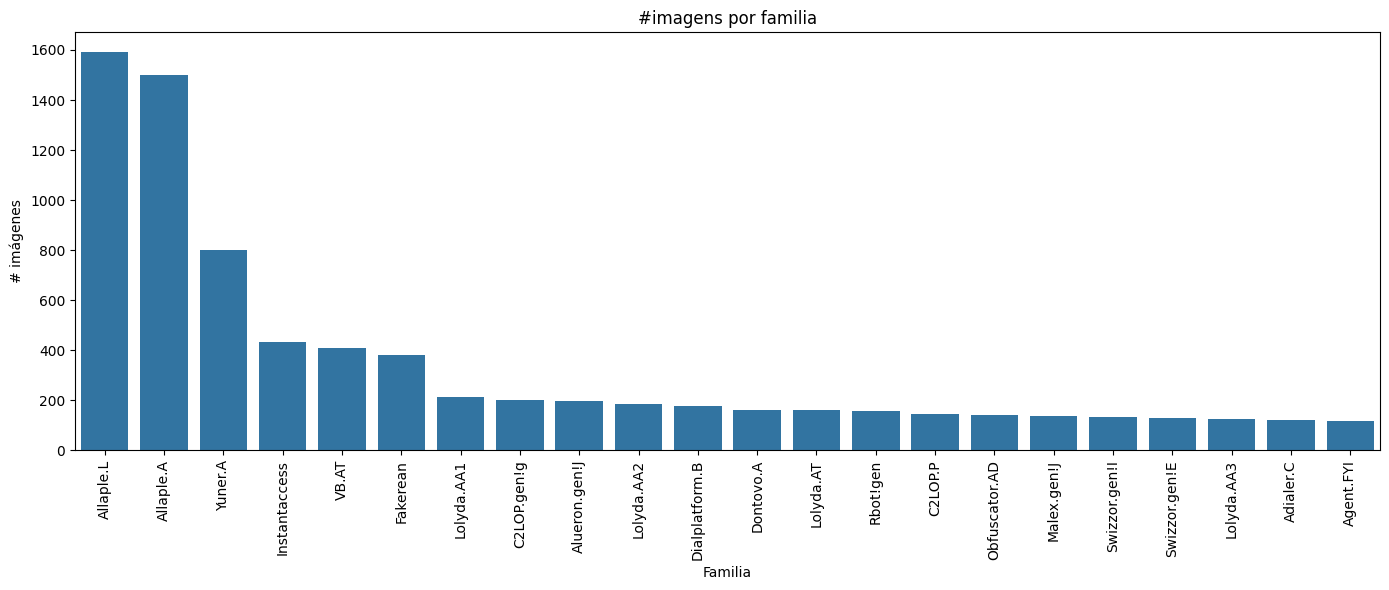

In [24]:
plt.figure(figsize=(14, 6))
sns.barplot(x=list(familiesCount.keys()), y=list(familiesCount.values()))
plt.xticks(rotation=90)
plt.title("#imagens por familia")
plt.xlabel("Familia")
plt.ylabel("# imágenes")
plt.tight_layout()
plt.show()

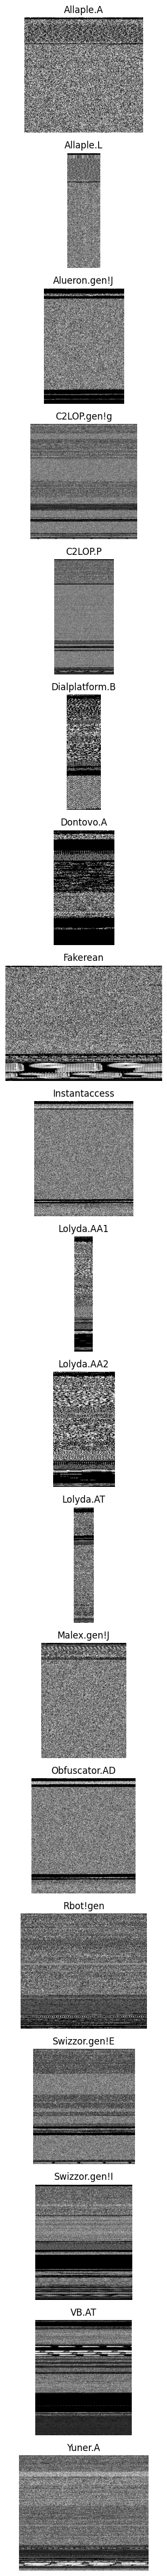

In [7]:
plt.figure(figsize=(15, len(families) * 2.5))

imgIndex = 1
for family in families:
    familyPath = os.path.join(datasetPath, family)
    images = os.listdir(familyPath)[:1]
    
    for imgName in images:
        imgPath = os.path.join(familyPath, imgName)
        img = mpimg.imread(imgPath)
        plt.subplot(len(families), 1, imgIndex)
        plt.imshow(img, cmap='gray')
        plt.title(family)
        plt.axis('off')
        imgIndex += 1

plt.tight_layout()
plt.show()


# Modelo

In [26]:
widths = []
highs = []

for family in families:
    familyPath = os.path.join(datasetPath, family)
    for imgName in os.listdir(familyPath):
        imgPath = os.path.join(familyPath, imgName)
        with Image.open(imgPath) as img:
            width, high = img.size
            widths.append(width)
            highs.append(high)

avgWidth = int(np.mean(widths))
avgHigh = int(np.mean(highs))

print(f"Tamaño promedio: {avgWidth} x {avgHigh}")

Tamaño promedio: 340 x 457


In [27]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(avgHigh, avgWidth, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(families), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

c:\Users\ealva\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 455, 338, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 455, 338, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 227, 169, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 227, 169, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 225, 167, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 225, 167, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 83, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 112, 83, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 110, 81, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 110, 81, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 55, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 55, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 281600)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    36,044,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 22)             │         2,838 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,141,334 (137.87 MB)

 Trainable params: 36,140,886 (137.87 MB)

 Non-trainable params: 448 (1.75 KB)

In [29]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [30]:
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.3)

train_generator = datagen.flow_from_directory(
    datasetPath,
    target_size=(avgHigh, avgWidth),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    datasetPath,
    target_size=(avgHigh, avgWidth),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

Found 5335 images belonging to 22 classes.
Found 2272 images belonging to 22 classes.
Epoch 1/10


c:\Users\ealva\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


167/167 ━━━━━━━━━━━━━━━━━━━━ 931s 6s/step - accuracy: 0.4224 - loss: 23.5401 - val_accuracy: 0.0158 - val_loss: 494.7514
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 948s 6s/step - accuracy: 0.5682 - loss: 1.6688 - val_accuracy: 0.0154 - val_loss: 621.7111
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 937s 6s/step - accuracy: 0.5584 - loss: 1.5976 - val_accuracy: 0.0348 - val_loss: 459.6172
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 981s 6s/step - accuracy: 0.5440 - loss: 1.4973 - val_accuracy: 0.1338 - val_loss: 385.1511
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 977s 6s/step - accuracy: 0.5252 - loss: 1.6853 - val_accuracy: 0.3935 - val_loss: 34.7410
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 963s 6s/step - accuracy: 0.4919 - loss: 1.6161 - val_accuracy: 0.6831 - val_loss: 1.9255
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 981s 6s/step - accuracy: 0.4990 - loss: 1.6636 - val_accuracy: 0.2702 - val_loss: 24.1508
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 951s 6s/step - accuracy: 0.5326 - loss: 1.6006 - val_accu

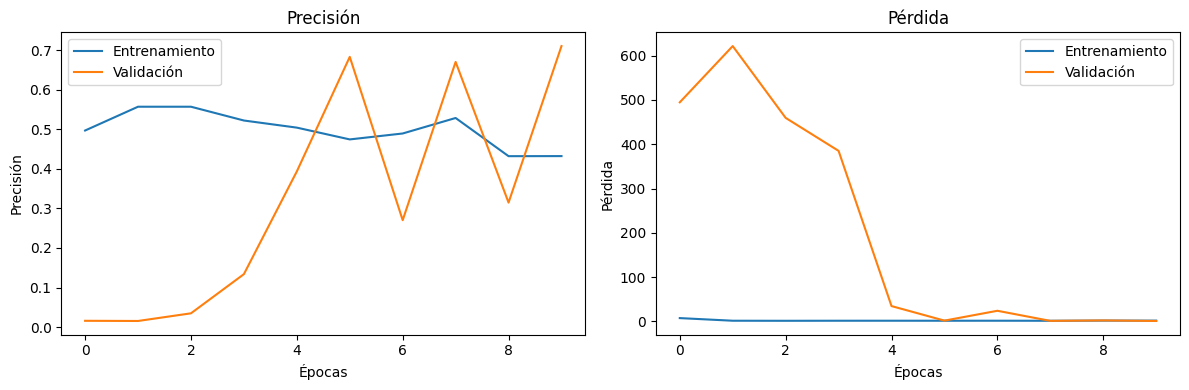

In [34]:
plt.figure(figsize=(12, 4))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save("malimg_model.h5")
model.save_weights("malimg_weights.weights.h5")

import pickle
with open("history.pk", "wb") as f:
    pickle.dump(history.history, f)

In [ ]:
loss, accuracy = model.evaluate(validation_generator, verbose=1)
print(f"Pérdida en validación: {loss:.4f}")
print(f"Precisión en validación: {accuracy:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 59s 820ms/step - accuracy: 0.6880 - loss: 1.2037
Pérdida en validación: 1.1220
Precisión en validación: 0.7104


Pues, claramente no es el mejor modelo. Mostró un comportamiento bastante inestable y se puede ver claramente en los gráficos de precisión y pérdida. Su precisión dejó bastante que desear, pues en las 10 épocas no llegó a converger de gran manera. Al ver cómo se comportó el modelo en la validación se podría decir que el modelo tiene problemas de generalización en las clases. La pérdida, aunque terminó en un valor bastante bajo su comportamiento no fue el idóneo, debido a su caida tran drástica luego de un pico curioso. Ya en la evaluación del modelo se cuenta con una validación de 71% lo cuál es bastante bueno, pero no es lo mejor. Aunque se implementaron técnicas para hacer que el modelo tuviera las mejores chances y no llegar a tener sesgos dentro de su clasificación, parace que no fue suficiente. Y tampoco muestra un comportamiento bueno como para decir que entrenándolo por más épocas llegaría a mostrar mejores resultados. Probablemente implementando un mejor balanceo de datos en el dataset y un manejo de pesos para evitar el sesgo haría que el modelo se comportara de mejor manera.